In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


True


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import shutil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from torchvision.utils import make_grid

from models import ConvVAE

In [5]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

In [6]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/ConvVAE"):
    os.makedirs("imgs/ConvVAE")

### a) AFHQ (Animal Faces-HQ) dataset

In [7]:
IMG_SIZE = 64

# Downloading and Loading Dataset
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Downsaple to 64x64
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform)

In [8]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=B_SIZE, 
        shuffle=True,
        num_workers=4
) 
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, 
        batch_size=B_SIZE,
        shuffle=False,
        num_workers=4
)

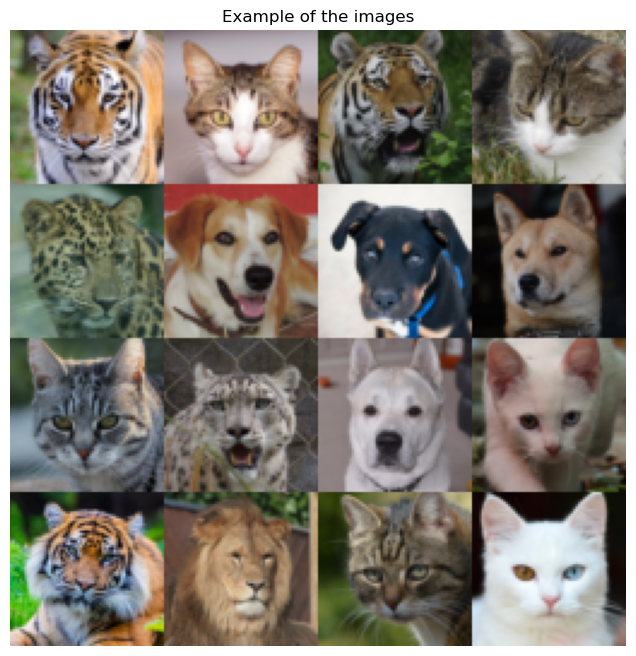

In [9]:
images, labels = next(iter(train_loader))

grid_img = make_grid(images[:16], nrow=4, padding=0, normalize=True)

np_img = grid_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 8))
plt.imshow(np_img)
plt.axis("off")
plt.title("Example of the images")
plt.show()

### b) Convolutional Variational Autoencoder (ConvVAE)

Defined in `models.py`

### c) Investigate the importance of the KL-divergence weight

In [10]:
EPOCHS = 10 # after 10 epochs there is no much improvement
LEARNING_RATE = 3e-3

In [ ]:
# import time

# kl_weights = [1e-4, 1e-3, 5e-3, 1e-2, 1e-1]
# models = {}
# training_stats = {}

# start_time = time.time()

# for weight in kl_weights:
#     print(f"\nTraining model with KL weight: {weight}")

#     model = ConvVAE()
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)

#     train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
#             model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
#             train_loader=train_loader, valid_loader=test_loader, num_epochs=EPOCHS,
#             device=device, kl_weight=weight
#         )
    
#     models[weight] = model

# end_time = time.time()
# diff_min = (end_time - start_time) / 60 

# print(f"Finished in {diff_min:.2f} minutes")


Training model with KL weight: 0.0001


    Train loss: 0.0485
    Valid loss: 0.06221
       Valid loss recons: 0.06221
       Valid loss KL-D:   0.00619
    Train loss: 0.02492
    Valid loss: 0.02605
       Valid loss recons: 0.02328
       Valid loss KL-D:   27.65797
Saved state to checkpoints/12-49_31-05-2025/checkpoint_epoch_5.pth
    Train loss: 0.0222
    Valid loss: 0.02219
       Valid loss recons: 0.01855
       Valid loss KL-D:   36.44635
    Train loss: 0.0212
    Valid loss: 0.02165
       Valid loss recons: 0.01764
       Valid loss KL-D:   40.03771
    Train loss: 0.02084
    Valid loss: 0.02072
       Valid loss recons: 0.01665
       Valid loss KL-D:   40.68812
Saved state to checkpoints/12-49_31-05-2025/checkpoint_epoch_10.pth
    Train loss: 0.02059
    Valid loss: 0.02068
       Valid loss recons: 0.01657
       Valid loss KL-D:   41.09982
Training completed

Training model with KL weight: 0.001
    Train loss: 0.05551
    Valid loss: 0.06177
       Valid loss recons: 0.06175
       Valid loss KL-D:   0.

In [ ]:
# model_dicts = {}

# for i, (kld, model) in enumerate(models.items()):
#     model_dicts[kld] = model.state_dict()

# torch.save(model_dicts, "checkpoints/trained_models.pth")

In [ ]:
loaded_dicts = torch.load("checkpoints/trained_models.pth")
trained_models = {}
for (kld, model) in loaded_dicts.items():
    trained_models[f"{kld}"] = ConvVAE().to(device)
    trained_models[f"{kld}"].load_state_dict(model)

In [12]:
kl_weights = [1e-4, 1e-3, 5e-3, 1e-2, 1e-1]
models = trained_models

### d) Generate new images by sampling latent vectors, investigate latent space and visualize some interpolations.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

N = 2000

COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

#### KL weight 1e-4

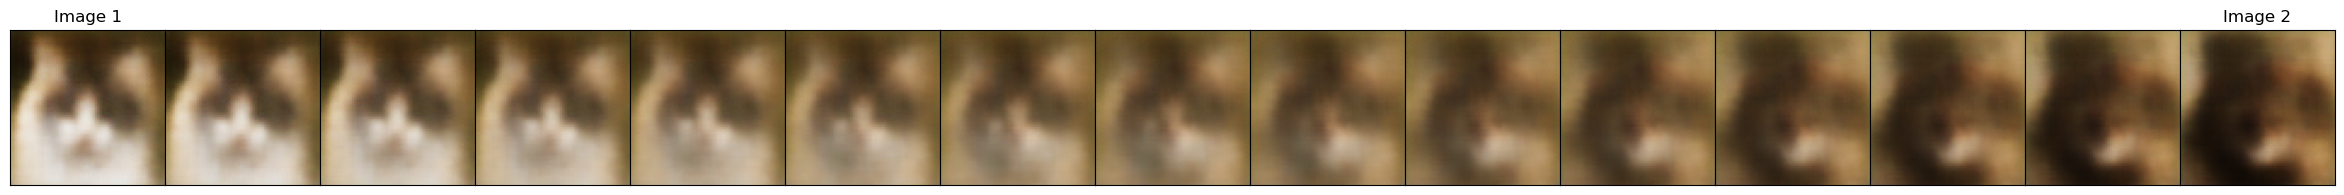

In [21]:
from utils.encode_samples import encode_samples
from utils.sample_interpolation import sample_interpolation
from utils.visualize_vector_samples import visualize_vector_samples

images, labels = next(iter(test_loader))
img1 = images[0]
img2 = images[1]

model = models[f"{kl_weights[0]}"]
p1, p2 = encode_samples(model, [img1, img2], device=device)
decoded_imgs = sample_interpolation(model=model, p1=p1, p2=p2, device=device)
visualize_vector_samples(decoded_imgs)

In [ ]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

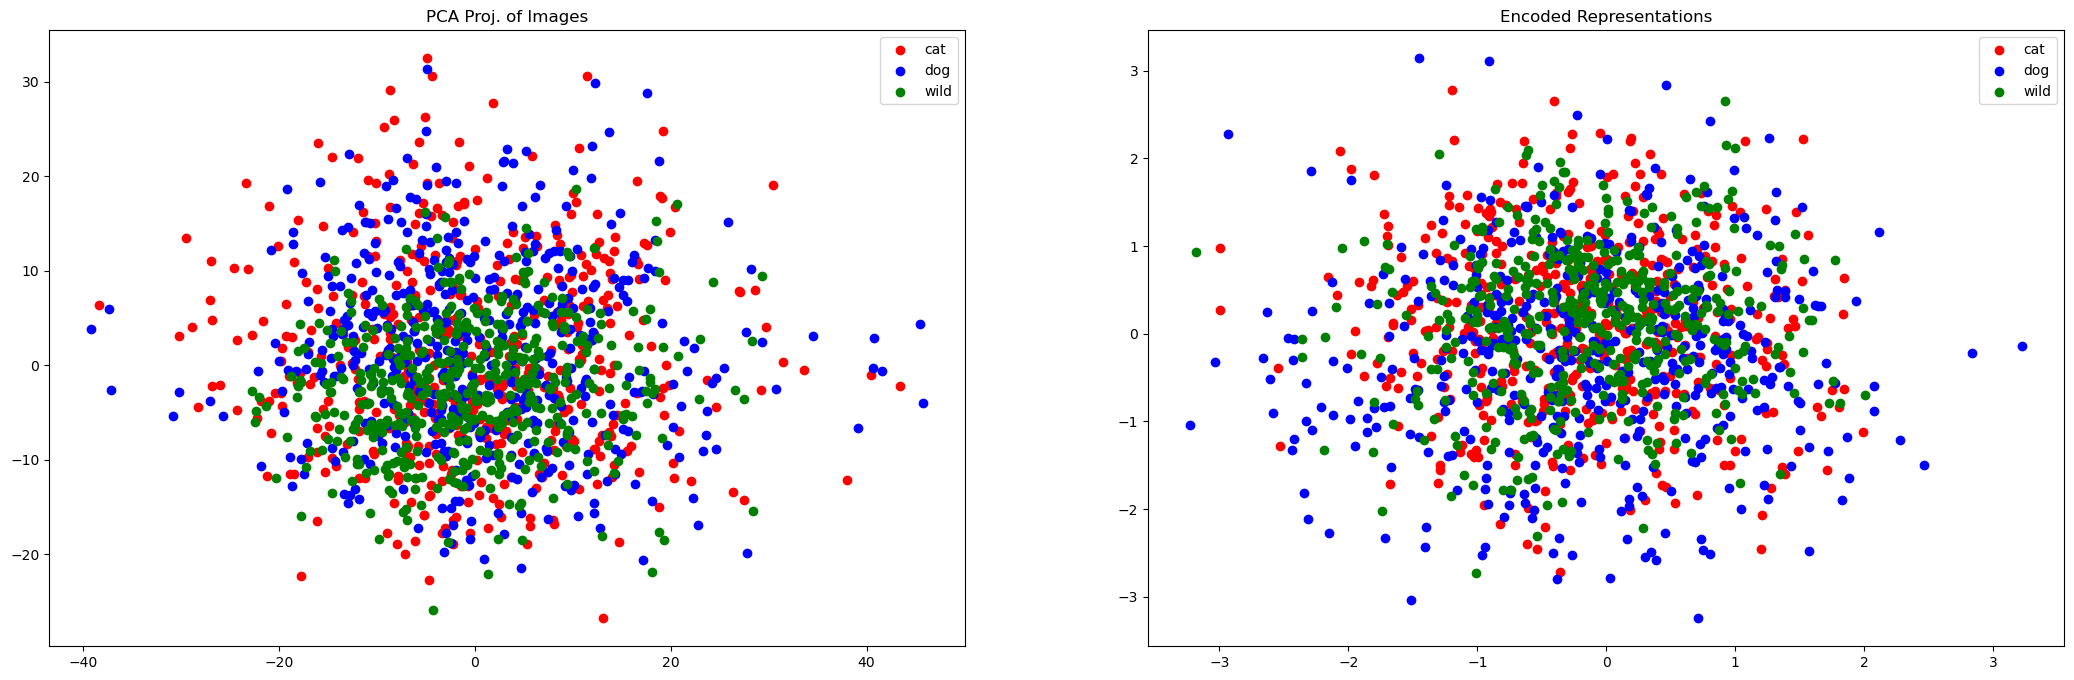

In [ ]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

#### KL weight 1e-1

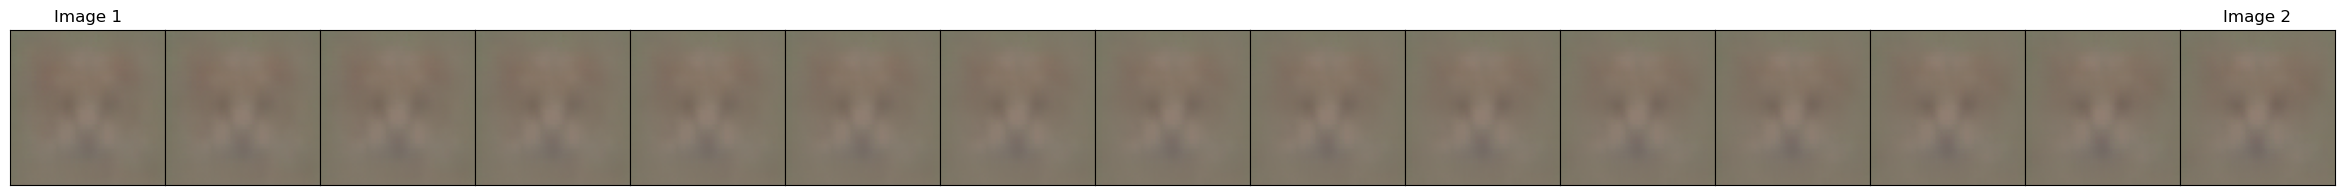

In [23]:
model = models[f"{kl_weights[-1]}"]
p1, p2 = encode_samples(model, [img1, img2], device=device)
decoded_imgs = sample_interpolation(model=model, p1=p1, p2=p2, device=device)
visualize_vector_samples(decoded_imgs)

In [26]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

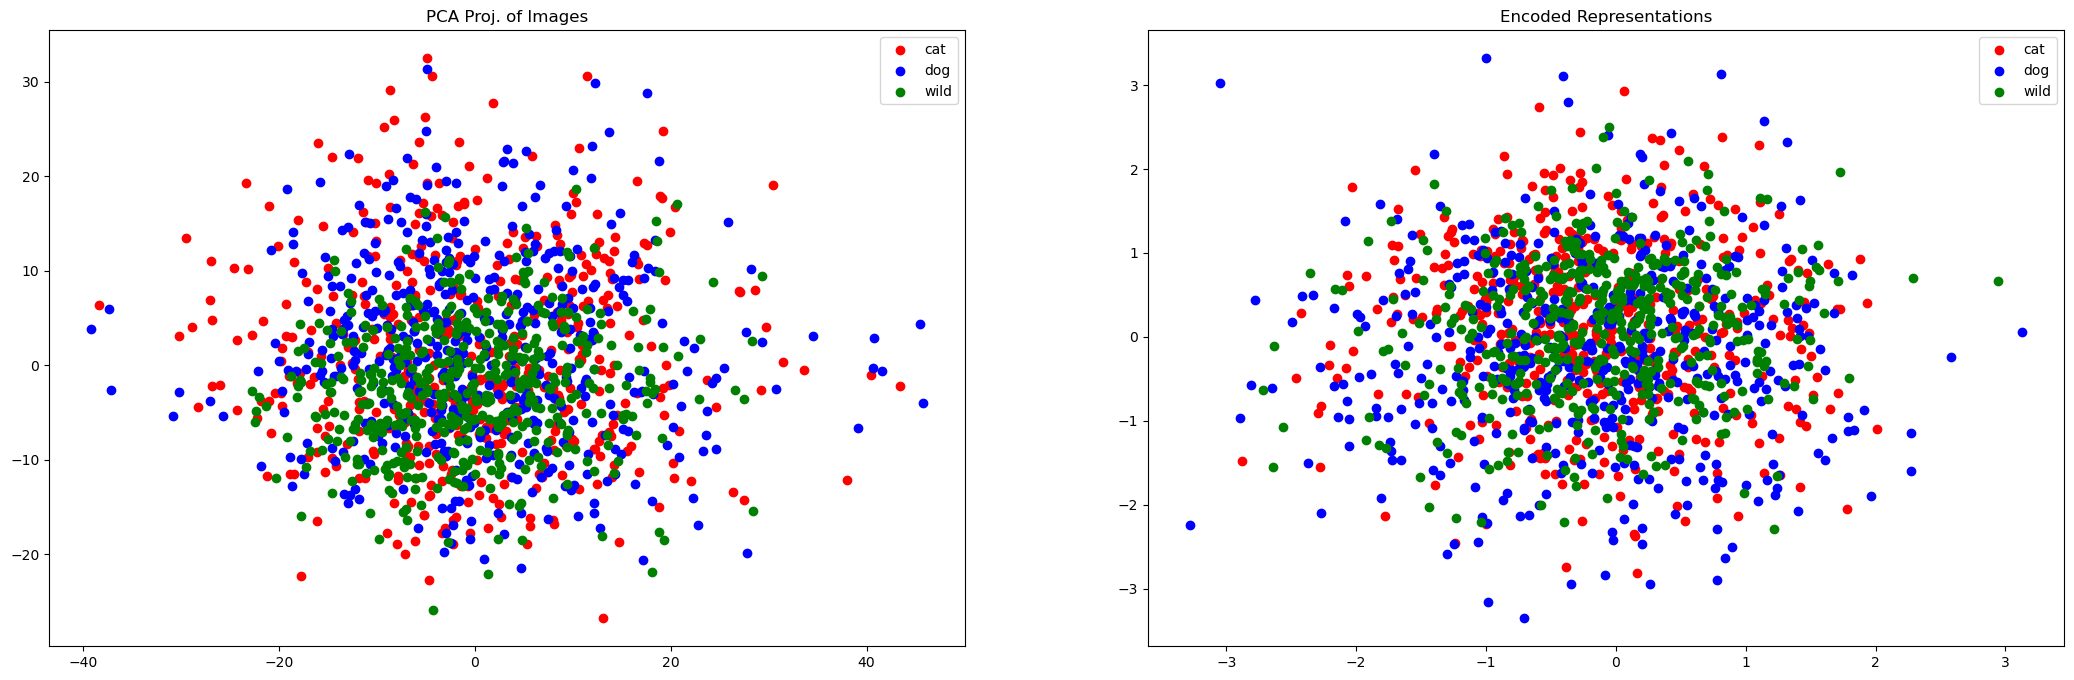

In [27]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

#### Analysis

From above we observe that a model with a lower KLD (in our case `1e-4`) produces more varied outputs. On the contrast, the bigger KLD (here `1e-1`) causes a model to make blurry and very similar images.

### e) Compare the models

In [ ]:
from utils.get_fid import get_fid

for kl_weight, model in models.items():
    fid = get_fid(model, test_loader, device, num_samples=1000)
    print(f"For KLD = {kl_weight}: FID = {fid:.2f}")

For KLD = 0.0001: FID = 207.75
For KLD = 0.001: FID = 251.69
For KLD = 0.005: FID = 295.55
For KLD = 0.01: FID = 326.84
For KLD = 0.1: FID = 360.65


Higher FID for bigger KL weights indicate more poor quality of the generations, which proves our previous qualitive analysis.